<a href="https://colab.research.google.com/github/saadAwd/Kaggle/blob/main/kOt7Mjt65N864EoU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install spacy

In [2]:
!python -m spacy download en_core_web_md


2023-10-07 04:58:06.674677: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-07 04:58:07.686237: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-10-07 04:58:09.440484: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-07 04:58:09.440983: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [3]:
import os
print(os.getcwd())

/content


files to be loaded:
*   validated.tsv
*   cloned_df.csv
*   real_embedded_vectors.csv
*   real_features.csv
*   fake_embedded_vectors.npy
*   fake_features (1).csv







In [9]:
from google.colab import files
uploaded = files.upload()

Saving fake_features (1).csv to fake_features (1).csv


In [10]:
import pandas as pd



# Define the file paths
original_file_path = "/content/validated.tsv"
new_file_path = "/content/sampled_real_voices.tsv"

# Read the original dataset
df_original = pd.read_csv(original_file_path, delimiter='\t')

# Randomly select 165 rows from the original dataset
df_sampled = df_original.sample(n=165, random_state=42)  # Adjust the random_state if needed

# Save the sampled dataset to a new file
df_sampled.to_csv(new_file_path, sep='\t', index=False)

In [11]:
import csv
import spacy
from itertools import islice

# Load the pre-trained word embeddings model
nlp = spacy.load("en_core_web_md")

# Path to the "other" TSV file containing the MP3 paths and sentences
sampled_file_path = "/content/sampled_real_voices.tsv"

# Batch size for processing sentences
batch_size = 100

# List to store the embedded vectors
embedded_vectors = []

# Read the TSV file in chunks
with open(sampled_file_path, "r") as tsvfile:
    reader = csv.reader(tsvfile, delimiter='\t')

    for chunk in iter(lambda: list(islice(reader, batch_size)), []):
        mp3_paths = []
        sentences = []

        for row in chunk:
            if len(row) >= 2:
                mp3_paths.append(row[1].strip())
                sentences.append(row[2].strip())

        # Perform text embedding on the sentences
        for sentence in sentences:
            doc = nlp(sentence)

            # Access the embedded vectors
            for token in doc:
                embedded_vectors.append(token.vector)

        # Perform text embedding on the MP3 paths
        for mp3_path in mp3_paths:
            doc = nlp(mp3_path)

            # Access the embedded vectors
            for token in doc:
                embedded_vectors.append(token.vector)

# Save the embedded vectors to a CSV file
output_file = "/content/real_embedded_vectors.npy"  # Update with the desired output file path

with open(output_file, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(embedded_vectors)

In [12]:
import pandas as pd
import spacy
import numpy as np

# Load the pre-trained word embeddings model
nlp = spacy.load("en_core_web_md")

# Path to the CSV file containing the fake voice data
fake_voices_file_path = "/content/cloned_df.csv"

# Batch size for processing sentences
batch_size = 100

# List to store the embedded vectors
embedded_vectors = []

# Read the CSV file in chunks
for chunk in pd.read_csv(fake_voices_file_path, chunksize=batch_size):
    # Extract the sentences from the chunk
    sentences = chunk["text"].tolist()

    # Perform text embedding on the sentences
    for sentence in sentences:
        # Perform text embedding on the sentence
        doc = nlp(sentence)

        # Access the embedded vectors
        for token in doc:
            embedded_vectors.append(token.vector)

# Convert the list of embedded vectors to a NumPy array
embedded_vectors = np.array(embedded_vectors)

# Save the embedded vectors to a file
output_file_path = "/content/fake_embedded_vectors.csv"  # Update with the desired output file path
np.save(output_file_path, embedded_vectors)

# New Section

In [13]:
import pandas as pd
import numpy as np

# Load real voice text embeddings
real_data = pd.read_csv('/content/real_embedded_vectors.csv')

# Load fake voice text embeddings from .npy file
fake_data = np.load('/content/fake_embedded_vectors.npy')

# Check the number of columns in real and fake data
if real_data.shape[1] != fake_data.shape[1]:
    print("Real data shape:", real_data.shape)
    print("Fake data shape:", fake_data.shape)
    raise ValueError("Number of columns in real and fake data do not match.")

# Duplicate the fake data to match the number of rows in the real data
num_duplicates = real_data.shape[0] // fake_data.shape[0]
fake_data = np.tile(fake_data, (num_duplicates, 1))

# Truncate the duplicated fake data to match the number of rows in the real data
num_extra_rows = real_data.shape[0] % fake_data.shape[0]
fake_data = np.concatenate((fake_data, fake_data[:num_extra_rows]), axis=0)

# Create a DataFrame for fake voice embeddings
fake_data = pd.DataFrame(fake_data, columns=real_data.columns)

# Add a column 'label' to indicate the class (0 for real, 1 for fake)
real_data['label'] = 0
fake_data['label'] = 1

# Concatenate the real and fake data
data = pd.concat([real_data, fake_data], ignore_index=True)

# Separate the features (text embeddings) and the target variable
X = data.drop('label', axis=1)
y = data['label']



In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a logistic regression classifier with increased max_iter
logreg = LogisticRegression(max_iter=1000)  # Set max_iter to your desired value
logreg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logreg.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 66.11%


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving fake voice.wav to fake voice.wav


In [15]:
!pip install speechRecognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 51.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import spacy
import joblib
from scipy.io import wavfile
import speech_recognition as sr

# Load the Spacy model with pre-trained word embeddings
nlp = spacy.load("en_core_web_md")


def speech_to_text(audio):
    """
    Return the text from the audio using automatic speech recognition (ASR).
    """
    r = sr.Recognizer()
    with sr.AudioFile(audio) as source:
        audio_data = r.record(source)
        text = r.recognize_google(audio_data)
        return text


# Load the voice file paths
voice_file_paths = ['/content/fake voice.wav']

# List to store the transcribed texts
transcribed_texts = []

# Process the voice files
for voice_file in voice_file_paths:
    # Convert voice data to text using ASR
    transcribed_text = speech_to_text(voice_file)

    # Append the transcribed text to the list
    transcribed_texts.append(transcribed_text)

# Create a DataFrame for the transcribed texts
transcribed_texts_df = pd.DataFrame({'Transcribed Text': transcribed_texts})

# Now you can use the transcribed texts for further processing or analysis
# For example, you can pass the transcribed texts to the Spacy model to extract embeddings
voice_file_embeddings = []

for transcribed_text in transcribed_texts:
    # Generate the text embedding using Spacy
    doc = nlp(transcribed_text)

    # Calculate the average of token vectors for the text embedding
    text_embedding = np.mean([token.vector for token in doc], axis=0)

    voice_file_embeddings.append(text_embedding)

# Create a DataFrame for the voice file embeddings
voice_file_embeddings = pd.DataFrame(voice_file_embeddings)


# Use the trained logistic regression classifier for prediction
predictions = logreg.predict(voice_file_embeddings)

if predictions == 1:
    print("This is a Fake voice")
else:
    print("This is a real voice")

This is a Fake voice


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving real voice.mp3 to real voice.mp3


In [ ]:
import pandas as pd
import numpy as np
import spacy
import joblib
from scipy.io import wavfile
import speech_recognition as sr
import subprocess

def convert_audio(input_file, output_file):
    subprocess.run(['ffmpeg', '-i', input_file, output_file])

# Provide the path to the input MP3 file and the desired output WAV file
input_file = '/content/real voice.mp3'
output_file = '/content/test_real_file.wav'

# Convert the MP3 file to WAV format
convert_audio(input_file, output_file)
# Load the Spacy model with pre-trained word embeddings
nlp = spacy.load("en_core_web_md")


def speech_to_text(audio):
    """
    Return the text from the audio using automatic speech recognition (ASR).
    """
    r = sr.Recognizer()
    with sr.AudioFile(audio) as source:
        audio_data = r.record(source)
        text = r.recognize_google(audio_data)
        return text


# Load the voice file paths
voice_file_paths = ['/content/test_real_file.wav']

# List to store the transcribed texts
transcribed_texts = []

# Process the voice files
for voice_file in voice_file_paths:
    # Convert voice data to text using ASR
    transcribed_text = speech_to_text(voice_file)

    # Append the transcribed text to the list
    transcribed_texts.append(transcribed_text)

# Create a DataFrame for the transcribed texts
transcribed_texts_df = pd.DataFrame({'Transcribed Text': transcribed_texts})

# Now you can use the transcribed texts for further processing or analysis
# For example, you can pass the transcribed texts to the Spacy model to extract embeddings
voice_file_embeddings = []

for transcribed_text in transcribed_texts:
    # Generate the text embedding using Spacy
    doc = nlp(transcribed_text)

    # Calculate the average of token vectors for the text embedding
    text_embedding = np.mean([token.vector for token in doc], axis=0)

    voice_file_embeddings.append(text_embedding)

# Create a DataFrame for the voice file embeddings
voice_file_embeddings = pd.DataFrame(voice_file_embeddings)


# Use the trained logistic regression classifier for prediction
predictions = logreg.predict(voice_file_embeddings)

if predictions == 1:
    print("This is a Fake voice")
else:
    print("This is a real voice")

This is a real voice


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [16]:
!apt-get install -y portaudio19-dev
!pip install pyaudio --no-cache-dir

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libportaudio2 libportaudiocpp0
Suggested packages:
  portaudio19-doc
The following NEW packages will be installed:
  libportaudio2 libportaudiocpp0 portaudio19-dev
0 upgraded, 3 newly installed, 0 to remove and 18 not upgraded.
Need to get 188 kB of archives.
After this operation, 927 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudio2 amd64 19.6.0-1.1 [65.3 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudiocpp0 amd64 19.6.0-1.1 [16.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 portaudio19-dev amd64 19.6.0-1.1 [106 kB]
Fetched 188 kB in 0s (434 kB/s)
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 120875 files and directories currently installed.)
Preparing to unpack .../libportaudio2_19.6.0-1.

In [17]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 79.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.1 MB/s eta 0:00:00


In [18]:
!pip install gensim

In [19]:
from gensim.models import KeyedVectors
from transformers import BertTokenizer, BertModel

In [20]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
!unzip '/content/drive/MyDrive/Colab Notebooks/glove.6B.zip' -d /content/gloVe6B

Archive:  /content/drive/MyDrive/Colab Notebooks/glove.6B.zip
  inflating: /content/gloVe6B/glove.6B.50d.txt  
  inflating: /content/gloVe6B/glove.6B.100d.txt  
  inflating: /content/gloVe6B/glove.6B.200d.txt  
  inflating: /content/gloVe6B/glove.6B.300d.txt  


In [22]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

glove_path = '/content/gloVe6B/glove.6B.100d.txt'
word2vec_output_path = '/content/gloVe6B/glove.6B.100d.word2vec.txt'

# Convert GloVe to Word2Vec format
glove2word2vec(glove_path, word2vec_output_path)

# Load the Word2Vec embeddings
glove_model = KeyedVectors.load_word2vec_format(word2vec_output_path, binary=False)

<ipython-input-22-02cc05f28b2f>:8: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_path, word2vec_output_path)


In [23]:
!pip install -q transformers

from transformers import BertTokenizer, BertModel

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Initialize the BERT model
bert_model = BertModel.from_pretrained('bert-base-uncased')

In [66]:
cloned_text_to_df = pd.read_csv('cloned_df.csv')

# Extract the 'text' column
cloned_texts = cloned_text_to_df['text'].tolist()
real_text = df_sampled['sentence'].tolist()



In [67]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel

# Load the transcribed text data from the source you used for training
transcribed_texts_cloned = cloned_texts


# GloVe Embeddings
glove_embeddings = []

for transcribed_text_cloned in transcribed_texts_cloned:
    tokens = transcribed_text_cloned.split()
    text_embedding = np.mean([glove_model[t] for t in tokens if t in glove_model], axis=0)
    glove_embeddings.append(text_embedding)

# Filter out empty or NaN embeddings
glove_embeddings = [embedding for embedding in glove_embeddings if embedding is not None and not np.isnan(embedding).any()]

# Convert the embeddings to a DataFrame
glove_embeddings_df_cloned = pd.DataFrame(glove_embeddings)

# BERT Embeddings
bert_embeddings = []

for transcribed_text_cloned in transcribed_texts_cloned:
    inputs = tokenizer.encode_plus(transcribed_text_cloned, add_special_tokens=True, return_tensors='pt')
    outputs = bert_model(**inputs)
    text_embedding = torch.mean(outputs.last_hidden_state, dim=1).squeeze().detach().numpy()
    bert_embeddings.append(text_embedding)

bert_embeddings_df_cloned = pd.DataFrame(bert_embeddings)

In [69]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel

# Load the transcribed text data from the source you used for training
transcribed_texts_real = real_text


# GloVe Embeddings
glove_embeddings = []

for transcribed_text_real in transcribed_texts_real:
    tokens = transcribed_text_real.split()
    text_embedding = np.mean([glove_model[t] for t in tokens if t in glove_model], axis=0)
    glove_embeddings.append(text_embedding)

# Filter out empty or NaN embeddings
glove_embeddings = [embedding for embedding in glove_embeddings if embedding is not None and not np.isnan(embedding).any()]

# Convert the embeddings to a DataFrame
glove_embeddings_df_real = pd.DataFrame(glove_embeddings)

# BERT Embeddings
bert_embeddings = []

for transcribed_text_real in transcribed_texts_real:
    inputs = tokenizer.encode_plus(transcribed_text_real, add_special_tokens=True, return_tensors='pt')
    outputs = bert_model(**inputs)
    text_embedding = torch.mean(outputs.last_hidden_state, dim=1).squeeze().detach().numpy()
    bert_embeddings.append(text_embedding)

bert_embeddings_df_real = pd.DataFrame(bert_embeddings)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [72]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Add a column 'label' to indicate the class (0 for real, 1 for fake)
bert_embeddings_df_real['label'] = 0
bert_embeddings_df_cloned['label'] = 1

# Concatenate the real and fake data
bert_data = pd.concat([bert_embeddings_df_real, bert_embeddings_df_cloned], ignore_index=True)

# Separate the features (text embeddings) and the target variable
Xbert = bert_data.drop('label', axis=1)
ybert = bert_data['label']
# Split the data into training and testing sets
Xbert_train, Xbert_test, ybert_train, ybert_test = train_test_split(Xbert, ybert, test_size=0.2, random_state=42)

# Initialize and train a logistic regression classifier with increased max_iter
logreg_bert = LogisticRegression(max_iter=1000)  # Set max_iter to your desired value
logreg_bert.fit(Xbert_train, ybert_train)

# Make predictions on the test set
y_pred_bert = logreg_bert.predict(Xbert_test)

# Evaluate the accuracy of the classifier for BERT
accuracy_bert = accuracy_score(ybert_test, y_pred_bert)
print("Logistic regression classifier Accuracy Results")
print("Accuracy for BERT: {:.2f}%".format(accuracy_bert * 100))

# Add a column 'label' to indicate the class (0 for real, 1 for fake)
glove_embeddings_df_real['label'] = 0
glove_embeddings_df_cloned['label'] = 1

# Concatenate the real and fake data
glove_data = pd.concat([glove_embeddings_df_real, glove_embeddings_df_cloned], ignore_index=True)

# Separate the features (text embeddings) and the target variable
Xglove = glove_data.drop('label', axis=1)
yglove = glove_data['label']
# Split the data into training and testing sets
Xglove_train, Xglove_test, yglove_train, yglove_test = train_test_split(Xglove, yglove, test_size=0.2, random_state=42)

# Initialize and train a logistic regression classifier with increased max_iter for Glove
logreg_glove = LogisticRegression(max_iter=1000)  # Set max_iter to your desired value
logreg_glove.fit(Xglove_train, yglove_train)

# Make predictions on the test set for Glove
y_pred_glove = logreg_glove.predict(Xglove_test)

# Evaluate the accuracy of the classifier for Glove
accuracy_glove = accuracy_score(yglove_test, y_pred_glove)
print("Accuracy for GloVe: {:.2f}%".format(accuracy_glove * 100))
print("Accuracy for spaCy: {:.2f}%".format(accuracy * 100))

Logistic regression classifier Accuracy Results
Accuracy for BERT: 86.36%
Accuracy for GloVe: 69.70%
Accuracy for spaCy: 66.11%


In [81]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Initialize and train a decision tree classifier
dt_classifier_bert = DecisionTreeClassifier()
dt_classifier_bert.fit(Xbert_train, ybert_train)

# Make predictions on the test set
y_pred_dt_bert = dt_classifier_bert.predict(Xbert_test)

# Evaluate the accuracy of the decision tree classifier for BERT
accuracy_dt_bert = accuracy_score(ybert_test, y_pred_dt_bert)
print("Decision Tree Classifier Accuracy Results")
print("Accuracy for BERT: {:.2f}%".format(accuracy_dt_bert * 100))

# Initialize and train a decision tree classifier
dt_classifier_glove = DecisionTreeClassifier()
dt_classifier_glove.fit(Xglove_train, yglove_train)

# Make predictions on the test set
y_pred_dt_glove = dt_classifier_glove.predict(Xglove_test)

# Evaluate the accuracy of the decision tree classifier for Glove
accuracy_dt_glove = accuracy_score(yglove_test, y_pred_dt_glove)
print("Accuracy for GloVe: {:.2f}%".format(accuracy_dt_glove * 100))

# Initialize and train a decision tree classifier
dt_classifier_spacy = DecisionTreeClassifier()
dt_classifier_spacy.fit(X_train, y_train)

# Make predictions on the test set
y_pred_dt_spacy = dt_classifier_spacy.predict(X_test)

# Evaluate the accuracy of the decision tree classifier for spaCy
accuracy_dt_spacy = accuracy_score(y_test, y_pred_dt_spacy)
print("Accuracy for SpaCy: {:.2f}%".format(accuracy_dt_spacy * 100))

Decision Tree Classifier Accuracy Results
Accuracy for BERT: 77.27%
Accuracy for GloVe: 60.61%
Accuracy for SpaCy: 70.92%


In [82]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Initialize and train an XGBoost classifier for BERT
xgb_classifier_bert = xgb.XGBClassifier()
xgb_classifier_bert.fit(Xbert_train, ybert_train)

# Make predictions on the test set
y_pred_xgb_bert = xgb_classifier_bert.predict(Xbert_test)

# Evaluate the accuracy of the XGBoost classifier for BERT
accuracy_xgb_bert = accuracy_score(ybert_test, y_pred_xgb_bert)
print("XGBoost Classifier Accuracy Results")
print("Accuracy for BERT: {:.2f}%".format(accuracy_xgb_bert * 100))

# Initialize and train an XGBoost classifier for GloVe
xgb_classifier_glove = xgb.XGBClassifier()
xgb_classifier_glove.fit(Xglove_train, yglove_train)

# Make predictions on the test set
y_pred_xgb_glove = xgb_classifier_glove.predict(Xglove_test)

# Evaluate the accuracy of the XGBoost classifier for GloVe
accuracy_xgb_glove = accuracy_score(yglove_test, y_pred_xgb_glove)
print("Accuracy for GloVe: {:.2f}%".format(accuracy_xgb_glove * 100))

# Initialize and train an XGBoost classifier for spaCy
xgb_classifier_spacy = xgb.XGBClassifier()
xgb_classifier_spacy.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb_spacy = xgb_classifier_spacy.predict(X_test)

# Evaluate the accuracy of the XGBoost classifier for spaCy
accuracy_xgb_spacy = accuracy_score(y_test, y_pred_xgb_spacy)
print("Accuracy for spaCy: {:.2f}%".format(accuracy_xgb_spacy * 100))

XGBoost Classifier Accuracy Results
Accuracy for BERT: 84.85%
Accuracy for GloVe: 66.67%
Accuracy for spaCy: 71.14%


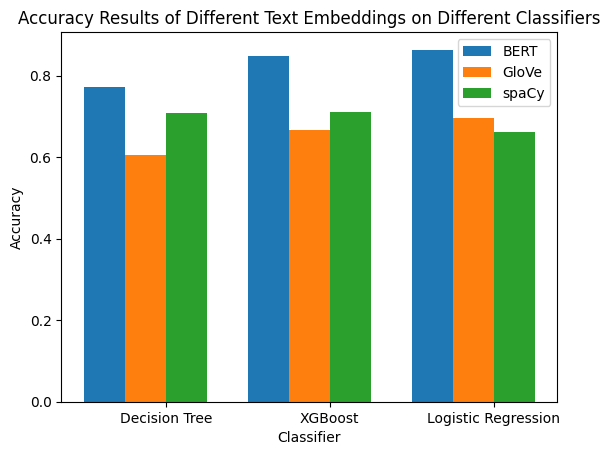

In [84]:
import matplotlib.pyplot as plt

# Accuracy results
accuracy_results = {
    'BERT': [accuracy_dt_bert, accuracy_xgb_bert, accuracy_bert],
    'GloVe': [accuracy_dt_glove, accuracy_xgb_glove, accuracy_glove],
    'spaCy': [accuracy_dt_spacy, accuracy_xgb_spacy, accuracy]
}

# Classifiers
classifiers = ['Decision Tree', 'XGBoost', 'Logistic Regression']

# Plotting the bar chart
fig, ax = plt.subplots()
bar_width = 0.25
index = np.arange(len(classifiers))

# Plotting accuracy results for each text embedding
for i, embedding in enumerate(accuracy_results.keys()):
    accuracies = accuracy_results[embedding]
    ax.bar(index + i * bar_width, accuracies, bar_width, label=embedding)

ax.set_xlabel('Classifier')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Results of Different Text Embeddings on Different Classifiers')
ax.set_xticks(index + bar_width * 1.5)
ax.set_xticklabels(classifiers)
ax.legend()

plt.show()